### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.getcwd())

import constants
from human_eval_utils import parse_python_code, construct_test_program, code_runs_without_errors, save_results, get_erratic_problems
from generic_agents.CodeInterpreterAgent import CodeInterpreterAgent
from utils import print_dict

### Loading the HumanEval Dataset

In [2]:
from human_eval_utils import load_human_eval

dataset = load_human_eval()

print(len(dataset))
task = dataset[-131]
# print a random example
print(task.keys())
print(task['prompt'])
print(task['entry_point'])
# print(task['test'])

164
dict_keys(['task_id', 'prompt', 'canonical_solution', 'test', 'entry_point'])


def sort_third(l: list):
    """This function takes a list l and returns a list l' such that
    l' is identical to l in the indicies that are not divisible by three, while its values at the indicies that are divisible by three are equal
    to the values of the corresponding indicies of l, but sorted.
    >>> sort_third([1, 2, 3])
    [1, 2, 3]
    >>> sort_third([5, 6, 3, 4, 8, 9, 2])
    [2, 6, 3, 4, 8, 9, 5]
    """

sort_third


### LangChain AgentCoder+




Initializing CodeInterpreterAgent with thread id:  Thread(id='thread_138sDgtBZwol69sUUurv5htW', created_at=1722347452, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=None, file_search=None)) 





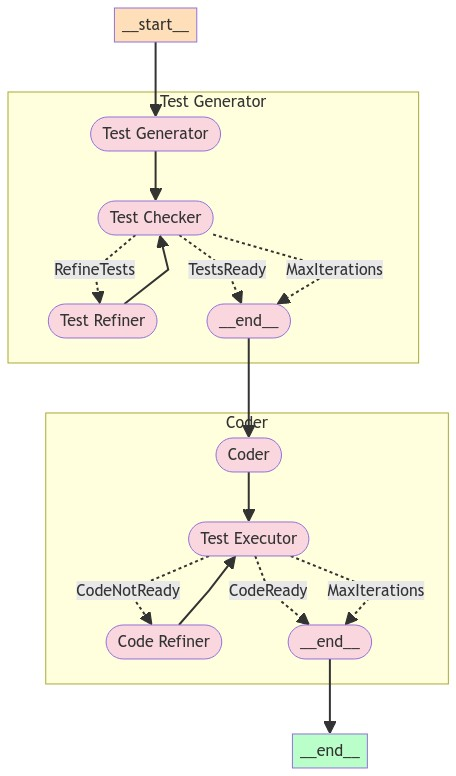

In [3]:
from langgraphs.agent_coder_plus import get_agent_coder_plus_graph
from IPython.display import Image, display

graph = get_agent_coder_plus_graph()
app = graph.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png())) 

def agent_coder_plus(task_prompt, max_iterations=3, passed_tests_threshold=0.7):
    config = {"recursion_limit": 50}
    inputs = {
        "incomplete_method": task_prompt,
        "max_iterations": max_iterations,
        "passed_tests_threshold": passed_tests_threshold,
    }

    for event in app.stream(inputs, config=config):
        print_dict(event)
    
    last_event_name = list(event.keys())[0]
    return event[last_event_name]['completed_method']

In [4]:
n_tasks = 5
task_numbers = range(n_tasks)
task_numbers = get_erratic_problems(file_path=constants.HUMAN_EVAL_SINGLE_AGENT_DIR)[:n_tasks]
print(task_numbers)
passed_tests_threshold = 0.7
max_iterations = 6

results = {
    "score": 0, 
    "test_counts": {"NoError": 0, "Error": 0, "AssertionError": 0, "IncorrectInput": 0}, 
    "erratic_problems": [],
    "tests_results": {}
}

n_correct = 0
for task_number in task_numbers:
    task = dataset[task_number]
    
    completion = agent_coder_plus(task['prompt'], max_iterations=max_iterations, passed_tests_threshold=passed_tests_threshold)

    test_path = constants.HUMAN_EVAL_AGENT_CODER_DIR + 'test_files/' + f'problem_{task_number}.py'
    test_program = construct_test_program(task['prompt'], completion, task['test'], task['entry_point'], save_path=test_path)
    (code_works, reason) = code_runs_without_errors(file_path=test_path)
    
    print(f'Problem {task_number} - Tests Passed: {code_works}' + f' - Reason: {reason if not code_works else ""}')
    print('\n-----------------------------------\n')
    if code_works:
        n_correct += 1
    else:
        results["erratic_problems"].append(task_number)
    if reason in results["test_counts"]:
        results["test_counts"][reason] += 1
    else:
        results["test_counts"][reason] = 1
    results["tests_results"][task_number] = (code_works, reason)

results["score"] = round(n_correct/n_tasks * 100, 4)
save_results(results, constants.HUMAN_EVAL_AGENT_CODER_PLUS_DIR)
print(f'Correct: {n_correct}/{n_tasks}')
print(results)

[32, 38, 41, 64, 65]
In AgentTestGenerator
In AgentTestChecker
In AgentTestRefiner
In AgentTestChecker
In AgentTestRefiner
In AgentTestChecker
Test Generator:
    incomplete_method:
        import math
        
        
        def poly(xs: list, x: float):
            """
            Evaluates polynomial with coefficients xs at point x.
            return xs[0] + xs[1] * x + xs[1] * x^2 + .... xs[n] * x^n
            """
            return sum([coeff * math.pow(x, i) for i, coeff in enumerate(xs)])
        
        
        def find_zero(xs: list):
            """ xs are coefficients of a polynomial.
            find_zero find x such that poly(x) = 0.
            find_zero returns only only zero point, even if there are many.
            Moreover, find_zero only takes list xs having even number of coefficients
            and largest non zero coefficient as it guarantees
            a solution.
            >>> round(find_zero([1, 2]), 2) # f(x) = 1 + 2x
            -0.5
            >>